### Unit 2 Lesson 2.7 Challenge: Feedback analysis 

Pick one of the company data files and build your own classifier. When you're satisfied with its performance (at this point just using the accuracy measure shown in the example), test it on one of the other datasets to see how well these kinds of classifiers translate from one context to another.

Include your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

### Feature Engineering: 

1. Review length: determine relationship between review length and sentiment

2. Keywords: Both positive and negative keywords.

3. Number of stop words: Determine number of (important) stop words in each review

4. Review length without Stopwords. 

5. potential (indepth) future analysis: https://medium.com/@datamonsters/sentiment-analysis-tools-overview-part-1-positive-and-negative-words-databases-ae35431a470c

In [709]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

In [710]:
file = './sentiment labelled sentences/yelp_labelled.txt'

sms_raw = pd.read_csv(file, delimiter= '\t', header=None)
sms_raw.columns = ['review', 'label']
sms_raw['simple_text'] = sms_raw['review'].str.lower()
sms_raw['simple_text'] = sms_raw['simple_text'].str.replace(".", " ")
sms_raw['simple_text'] = sms_raw['simple_text'].str.rstrip('.!? \n\t')
sms_good = sms_raw
sms_bad = sms_raw.loc[:, ['label', 'simple_text']]
sms_raw.head()

,review,label,simple_text
0,Wow... Loved this place.,1,wow loved this place
1,Crust is not good.,0,crust is not good
2,Not tasty and the texture was just nasty.,0,not tasty and the texture was just nasty
3,Stopped by during the late May bank holiday of...,1,stopped by during the late may bank holiday of...
4,The selection on the menu was great and so wer...,1,the selection on the menu was great and so wer...


## 1. Review length 

In [711]:
sms_raw['length'] = sms_raw['simple_text'].str.len()
## alternative method: 
# sms_raw['length2'] = sms_raw.review.apply(len)
bad = sms_raw.loc[sms_raw['label'] == 0]
good = sms_raw.loc[sms_raw['label'] != 0]

length1 = bad['review'].str.len()
length2 = good['review'].str.len()
print("bad review average length: {}, good review averge length: {}".format(length1.mean(), length2.mean()))

bad review average length: 60.75, good review averge length: 55.882


- No real difference in average length between positive and negative reviews

In [712]:
sms_raw.loc[0:4, ['label','simple_text',  'length']]

,label,simple_text,length
0,1,wow loved this place,23
1,0,crust is not good,17
2,0,not tasty and the texture was just nasty,40
3,1,stopped by during the late may bank holiday of...,86
4,1,the selection on the menu was great and so wer...,58


## 2. Keyword Analysis

#### Determining which keywords are most present in the data:

In [713]:
## Keyword Significance Test

possible_words = ['good', 'loved', 'great', 'five', 'superb', 
                 'quick', 'delicous', 'delightful', 'liked', 'fun', 'enjoyed', 'again', 
                 'happy', 'not', 'bad', 'unhappy', 'wasted', 'underwhelming', 'gone'
                 'shouldn\'t', 'should', 'disappointed', 'found', 'else', 
                 'problem', 'lacked', 'bit', 'below', 'average', 'nasty', 'unfortunately', 'no problem']

cache = {}

for i in possible_words:
    x = 0
    for j in sms_raw['simple_text']:
        if i in j:
            x+=1
            cache.update({i : x})
sorted(cache.items(),  key = lambda x:x[1], reverse=True)

[('not', 132),
 ('good', 91),
 ('great', 65),
 ('again', 24),
 ('disappointed', 19),
 ('bad', 17),
 ('bit', 14),
 ('loved', 10),
 ('quick', 8),
 ('happy', 8),
 ('found', 8),
 ('should', 7),
 ('else', 7),
 ('fun', 5),
 ('enjoyed', 5),
 ('average', 4),
 ('unfortunately', 4),
 ('liked', 3),
 ('lacked', 3),
 ('nasty', 3),
 ('delightful', 2),
 ('underwhelming', 2),
 ('five', 1),
 ('wasted', 1),
 ('problem', 1),
 ('below', 1)]

### Feature Engineering a continous variable for 'good' and 'bad' keywords 

process:
- From list of key words, create categorical variable for each word based on it's presense in the review

- Change the Boolean(Categorical) var into a 1 or 0

- Sum the number of present keywords 

- Concatinate results into final dataframe

In [714]:
good_words = ['good', 'great', 'again', 'happy', 'quick', 'fun', 'enjoyed', 'liked', 'delightful', 'love']
for key in good_words:
    sms_good[str(key)] = sms_good.simple_text.str.contains(
        str(key),
        )
    
sms_good[0:5]

,review,label,simple_text,length,good,great,again,happy,quick,fun,enjoyed,liked,delightful,love
0,Wow... Loved this place.,1,wow loved this place,23,False,False,False,False,False,False,False,False,False,True
1,Crust is not good.,0,crust is not good,17,True,False,False,False,False,False,False,False,False,False
2,Not tasty and the texture was just nasty.,0,not tasty and the texture was just nasty,40,False,False,False,False,False,False,False,False,False,False
3,Stopped by during the late May bank holiday of...,1,stopped by during the late may bank holiday of...,86,False,False,False,False,False,False,False,False,False,True
4,The selection on the menu was great and so wer...,1,the selection on the menu was great and so wer...,58,False,True,False,False,False,False,False,False,False,False


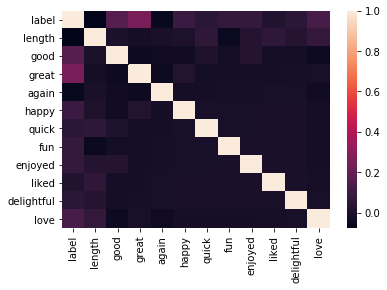

In [715]:
## extra: looks like good and great have a larger impact on the label
# sms_good['label'] = (sms_good['label'] == 1)
sns.heatmap(sms_good.corr())

In [716]:
replaced_bool = sms_good.loc[:, 'good':'love'].apply(np.ceil, axis = 1)
replaced_bool['g_sum'] = replaced_bool.apply(sum, axis = 1)
x = replaced_bool['g_sum']
x
y = sms_good.loc[:, 'label': 'length']
z = pd.concat([y, x], axis = 1)
z.head()

,label,simple_text,length,g_sum
0,1,wow loved this place,23,1.0
1,0,crust is not good,17,1.0
2,0,not tasty and the texture was just nasty,40,0.0
3,1,stopped by during the late may bank holiday of...,86,1.0
4,1,the selection on the menu was great and so wer...,58,1.0


In [717]:
bad_words = ['not', 'disappointed', 'bad', 'should', 'else', 'unfortunately', 'lacked']
for key in bad_words:
    sms_bad[str(key)] = sms_bad.simple_text.str.contains(
        str(key),
        )
    
sms_bad[0:5]

,label,simple_text,not,disappointed,bad,should,else,unfortunately,lacked
0,1,wow loved this place,False,False,False,False,False,False,False
1,0,crust is not good,True,False,False,False,False,False,False
2,0,not tasty and the texture was just nasty,True,False,False,False,False,False,False
3,1,stopped by during the late may bank holiday of...,False,False,False,False,False,False,False
4,1,the selection on the menu was great and so wer...,False,False,False,False,False,False,False


In [718]:
replaced_bool = sms_bad.loc[:, 'not':'lacked'].apply(np.ceil, axis = 1)
replaced_bool['b_sum'] = replaced_bool.apply(sum, axis = 1)
x = replaced_bool['b_sum']
y = sms_bad.loc[:,  'label':'simple_text']
z2 = pd.concat([y, x], axis = 1)

In [719]:
b = z2.loc[:, ['b_sum']]
df = pd.concat([z, b], axis = 1)

### Final dataframe:

Includes the label, initial text, along with sum of good and words present in each review

In [720]:
df.head()

,label,simple_text,length,g_sum,b_sum
0,1,wow loved this place,23,1.0,0.0
1,0,crust is not good,17,1.0,1.0
2,0,not tasty and the texture was just nasty,40,0.0,1.0
3,1,stopped by during the late may bank holiday of...,86,1.0,0.0
4,1,the selection on the menu was great and so wer...,58,1.0,0.0


In [721]:
#df['label'] = (df['label'] == 0)
#sns.heatmap(df.corr())

In [722]:
#df['label'] = (df['label'] == 1)
#sns.heatmap(df.corr())

## 3. Stop Words

### Significance (same as keywords)

In [723]:
stpwrds = set(stopwords.words('english'))
# nltk.download()
# stpwrds

cache = {}

for i in stpwrds:
    x = 0 
    h = ' '+ i + ' '
    for j in sms_raw['simple_text']:
        if h in j: 
            x += 1
            cache.update({i : x})
sorted(cache.items(), key = lambda x :x[1], reverse=True)            

[('the', 332),
 ('and', 329),
 ('was', 258),
 ('a', 194),
 ('to', 178),
 ('is', 151),
 ('i', 144),
 ('of', 118),
 ('not', 101),
 ('for', 95),
 ('in', 94),
 ('this', 87),
 ('it', 75),
 ('with', 67),
 ('be', 64),
 ('had', 63),
 ('very', 61),
 ('have', 60),
 ('so', 58),
 ('are', 58),
 ('were', 57),
 ('that', 56),
 ('but', 56),
 ('at', 52),
 ('my', 51),
 ('on', 47),
 ('you', 43),
 ('we', 40),
 ('they', 37),
 ('here', 37),
 ('our', 34),
 ('just', 30),
 ('will', 29),
 ('all', 28),
 ('an', 28),
 ('as', 26),
 ('only', 23),
 ('your', 23),
 ("don't", 22),
 ('there', 22),
 ('been', 21),
 ('their', 21),
 ('up', 20),
 ('out', 20),
 ('which', 19),
 ('from', 19),
 ('or', 19),
 ('no', 19),
 ('by', 18),
 ("won't", 17),
 ('some', 17),
 ('about', 17),
 ('more', 16),
 ('what', 16),
 ('did', 16),
 ('if', 15),
 ('has', 15),
 ('when', 15),
 ('other', 14),
 ('being', 14),
 ('than', 14),
 ('because', 14),
 ('can', 14),
 ('me', 14),
 ("didn't", 13),
 ('how', 13),
 ("wasn't", 13),
 ('them', 11),
 ("it's", 11),
 

#### Removable words

In [724]:
## Future: write function that takes key from dictionary and creates this list
removable_words = ['the', 'and', 'was', 'a', 'to', 'is', 'i', 'of', 'not', 'for', 'in', 'this'
                  'it', 'with', 'be', 'had', 'very', 'have', 'are', 'so', 'were', 'that', 'but', 'at', 'my', 'on', 'you',
                   'we', 'they', 'here', 'our', 'just', 'will', 'all', 'an', 'as', 'your', 'only', 
                   'there', 'their', 'been', 'out', 'or', 'from', 'which', 'by', 'about', 'some', 'more', 'did', 
                   'has', 'what', 'if', 'when', 'because', 'other', 'being', 'than', 'how', 'me', 'he',
                   'them', 'do', 'too',]
start = sms_raw.loc[:, ['simple_text']]

In [725]:
start.head()

,simple_text
0,wow loved this place
1,crust is not good
2,not tasty and the texture was just nasty
3,stopped by during the late may bank holiday of...
4,the selection on the menu was great and so wer...


In [726]:
for key in removable_words:
    start[str(key)] = start.simple_text.str.contains(
        str(key),
        )
    
start[0:5]

,simple_text,the,and,was,a,to,is,i,of,not,...,because,other,being,than,how,me,he,them,do,too
0,wow loved this place,False,False,False,True,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,crust is not good,False,False,False,False,False,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
2,not tasty and the texture was just nasty,True,True,True,True,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,stopped by during the late may bank holiday of...,True,True,False,True,True,False,True,True,False,...,False,False,False,False,False,True,True,False,False,False
4,the selection on the menu was great and so wer...,True,True,True,True,False,False,True,False,False,...,False,False,False,False,False,True,True,False,False,False


In [727]:
replaced_bool = start.loc[:, 'the':'too'].apply(np.ceil, axis = 1)
replaced_bool['stop_words_sum'] = replaced_bool.apply(sum, axis = 1)


In [728]:
replaced_bool.head()

,the,and,was,a,to,is,i,of,not,for,...,other,being,than,how,me,he,them,do,too,stop_words_sum
0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0
3,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,13.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,14.0


In [729]:
x = replaced_bool['stop_words_sum']
df1 = pd.concat([df,x], axis=1 )

In [730]:
df1.describe()

,label,length,g_sum,b_sum,stop_words_sum
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.50000,57.235000,0.247000,0.189000,9.653000
std,0.50025,32.399406,0.454089,0.414066,4.434214
min,0.00000,9.000000,0.000000,0.000000,0.000000
25%,0.00000,32.000000,0.000000,0.000000,6.000000
50%,0.50000,50.000000,0.000000,0.000000,9.000000
75%,1.00000,79.000000,0.000000,0.000000,13.000000
max,1.00000,148.000000,2.000000,2.000000,24.000000


In [731]:
def funct(val):
    if val > 10:
        return 1
    else: 
        return 0   
df1['tilt'] = df1.loc[:, 'stop_words_sum'].apply(funct)

In [732]:
df1

,label,simple_text,length,g_sum,b_sum,stop_words_sum,tilt
0,1,wow loved this place,23,1.0,0.0,3.0,0
1,0,crust is not good,17,1.0,1.0,3.0,0
2,0,not tasty and the texture was just nasty,40,0.0,1.0,9.0,0
3,1,stopped by during the late may bank holiday of...,86,1.0,0.0,13.0,1
4,1,the selection on the menu was great and so wer...,58,1.0,0.0,14.0,1
5,0,now i am getting angry and i want my damn pho,45,0.0,0.0,6.0,0
6,0,honeslty it didn't taste that fresh ),37,0.0,0.0,7.0,0
7,0,the potatoes were like rubber and you could te...,110,0.0,0.0,19.0,1
8,1,the fries were great too,24,1.0,0.0,9.0,0
9,1,a great touch,13,1.0,0.0,3.0,0


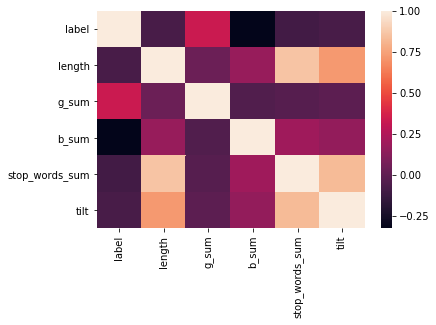

In [733]:
#df1['label'] = (df1['label'] == 1)
sns.heatmap(df1.corr())

In [734]:
df1.describe()

,label,length,g_sum,b_sum,stop_words_sum,tilt
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.50000,57.235000,0.247000,0.189000,9.653000,0.422000
std,0.50025,32.399406,0.454089,0.414066,4.434214,0.494126
min,0.00000,9.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,32.000000,0.000000,0.000000,6.000000,0.000000
50%,0.50000,50.000000,0.000000,0.000000,9.000000,0.000000
75%,1.00000,79.000000,0.000000,0.000000,13.000000,1.000000
max,1.00000,148.000000,2.000000,2.000000,24.000000,1.000000


## Modeling

In [735]:
data = df1.loc[:, 'length':'tilt']
target = df1['label']

In [737]:
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 348


In [740]:
(1000 - 348) / 1000

0.652

### Lower Case all reviews
